In [1]:
#import axion_ppa
import os
os.chdir("../")
import ppa
import numpy as np
import matplotlib.pyplot as plt
import json
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.interpolate as si



import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import scipy.constants as sc
from astropy.time import Time
from scipy.sparse import bmat

import matplotlib
plt.rc('font',**{'family':'serif','serif':['Times']})
mpl.rcParams['font.size'] = 13
#mpl.rcParams['font.family'] = 'serif'
#mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['patch.linewidth'] = 1

# Changing this will affect the size of the plot in Jupyter notebook as well as resolution of the final PDF. Can change later
plt.rcParams['figure.dpi'] = 100

#mpl.rcParams['mathtext.fontset'] = 'custom'
#mpl.rcParams['mathtext.rm'] = 'Serif'
#mpl.rcParams['mathtext.it'] = 'Serif:italic'
#mpl.rcParams['mathtext.bf'] = 'Serif:bold'

# tick parameters:
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True


mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
    
mpl.rcParams['xtick.major.size'] = 6  # default 3.5
mpl.rcParams['ytick.major.size'] = 6  # default 3.5
mpl.rcParams['xtick.minor.size'] =  3  # default 2 
mpl.rcParams['ytick.minor.size'] = 3  # default 2 
    
mpl.rcParams['xtick.major.width'] = 1  # default 0.8
mpl.rcParams['ytick.major.width'] = 1  # default 0.8
mpl.rcParams['xtick.minor.width'] =1  # default 0.6
mpl.rcParams['ytick.minor.width'] = 1  # default 0.6
mpl.rcParams['text.usetex'] = True




PSR_DICT= ppa.Load_All_Pulsar_Info()
PSR_NAME_LIST = list(PSR_DICT.keys())
with open("./ppa/Parfile/spa_results.json",'r') as f:
    spa_results = json.load(f)

In [14]:
a = []
k=1
for i in range(100):
    try:
        psr=ppa.Pulsar( PSR_DICT[PSR_NAME_LIST[i]],iono="ionfr" ,order=2)
        print(k,psr.PSR_NAME,psr.NOBS[0] \
              , "|%.1f"%((psr.TOAs[0].max() -psr.TOAs[0].min())/sc.year ) \
                , "|%.2f"%(np.median(psr.DPA_ERR)/np.pi*180 )\
                , "|%.2f"%(np.std(psr.DPA)/np.pi*180 ) ) 
        k+= 1
        if len(psr.TOAs[0]==0):
            a.append(psr.NOBS)
    except:
        pass
np.sum(a)

1 J0437-4715 1122 |18.0 |0.13 |0.91
2 J0613-0200 333 |17.5 |8.02 |8.21
3 J0614-3329 37 |2.8 |4.46 |3.22
4 J0711-6830 371 |17.8 |7.68 |9.05
5 J1017-7156 348 |11.4 |3.46 |4.09
6 J1022+1001 334 |17.9 |0.86 |1.19
7 J1024-0719 221 |17.8 |1.88 |1.89
8 J1045-4509 274 |16.7 |2.50 |2.57
9 J1125-6014 164 |7.4 |2.66 |2.20
10 J1545-4550 185 |10.1 |0.92 |1.09
11 J1600-3053 305 |18.0 |0.98 |1.31
12 J1603-7202 293 |18.0 |4.69 |5.41
13 J1643-1224 274 |17.9 |1.89 |2.26
14 J1713+0747 319 |17.1 |0.43 |1.17
15 J1730-2304 226 |17.9 |0.86 |1.35
16 J1744-1134 329 |18.0 |0.39 |0.72
17 J1824-2452 120 |15.8 |1.09 |1.10
18 J1857+0943 182 |17.6 |6.01 |6.51
19 J1909-3744 918 |18.0 |0.71 |1.75
20 J1939+2134 162 |16.3 |2.01 |1.87
21 J2145-0750 299 |17.8 |2.89 |3.10
22 J2241-5236 355 |12.0 |5.17 |4.59


7171

In [3]:
# plt.figure(figsize=(5,3*22))
# k=0
# for i,p in enumerate(PSR_NAME_LIST):
#     try:
#         plt.subplot(22,1,k+1)
#         psr = PSR_DICT[p]
#         psr["RM"]["10cm"]
#         RMdata = np.loadtxt(psr["RM"]["10cm"])
#         plt.errorbar( RMdata[0] , -RMdata[1] , [RMdata[2],RMdata[2]],ecolor=['blue','red'],lw=0.5 )
#         plt.title(p)
#         if k==-1:
#             plt.xlabel("MJD")

#         plt.ylabel(r"RM$_{\rm iono}$   rad/m$^2$")
#         plt.grid()
#         k+=1

#     except:
#         pass
# plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()
# plt.savefig("RM_iono_10cm.pdf")
# plt.close()

# Test likelihood function

In [4]:
order=2
pulsars_ionfr_10 = []
pulsars_noiono_10 =[]
for psrn in PSR_DICT:
    nfreqs_dict_psr = {}  
    white_noise_dict_psr = {}
    for key in spa_results[psrn].keys():
        psr_noise = spa_results[psrn][key]
        lbf1,lbf2,lbf3,lbf4 = psr_noise[4]

        if lbf3 > 2.3:
            white_noise_dict_psr.update( { key : "vary" } )
            #white_noise_dict_psr.update( { key : [psr_noise[0] , psr_noise[1]] } ) 
        else:
            white_noise_dict_psr.update( { key : "vary" } )
            
        if  lbf4 > 2.3:
            if psr_noise[3] <= -3:#
                nfreqs_dict_psr.update( { key : 5 } )
            elif psr_noise[3] > -3:
                nfreqs_dict_psr.update( { key : 30 } )
        else:
            nfreqs_dict_psr.update( { key : 0 } )

    pulsar_ionfr_10 = ppa.Pulsar(PSR_DICT[psrn],order = order \
                        , iono = "ionfr" , subset="10cm"
                        , nfreqs_dict=nfreqs_dict_psr , white_noise_dict = white_noise_dict_psr )
    pulsar_noiono_10 = ppa.Pulsar(PSR_DICT[psrn],order = order \
                        , iono = "noiono" , subset="10cm"
                        , nfreqs_dict=nfreqs_dict_psr , white_noise_dict = white_noise_dict_psr )
    
    
    pulsars_ionfr_10.append( pulsar_ionfr_10 )
    pulsars_noiono_10.append( pulsar_noiono_10 )   

array = ppa.Array( pulsars_ionfr_10 )
lnlike0 = array.Generate_Lnlike_Function("none")
lnlike1 = array.Generate_Lnlike_Function("auto")
lnlike2 = array.Generate_Lnlike_Function("full")


NPSR = array.NPSR
NSS = array.NSUBSETS_TOTAL
print(NPSR,NSS)


def Mapper(params):

    l10_EFAC = params[:NSS]
    l10_EQUAD = params[NSS:2*NSS]
    l10_S0 = params[2*NSS:3*NSS]
    Gamma = params[3*NSS:4*NSS]
    sDTE = params[4*NSS : 4*NSS+NPSR]
    l10_ma = params[4*NSS+NPSR ]
    l10_Sa = params[4*NSS+NPSR + 1]

    return l10_EFAC , l10_EQUAD , l10_S0 , Gamma , sDTE  , l10_ma , l10_Sa

all10 = []
for i in range(len(array.PSR_NAMES)):
    if PSR_NAME_LIST[i] in array.PSR_NAMES:
        all10.append(i)
#print(all10)

init = [ *array.Load_bestfit_params() , np.ones(NPSR),-22.0,-6]


22 22


In [5]:
print(len(array.FREQS[0][0]))
print(lnlike0(*init))
print(lnlike1(*init))
print(lnlike2(*init))

30
14480.79737358903
14480.797376300497
14480.797370179096


In [ ]:
# plt.figure(figsize=(5,3*22))
# k=0
# for i,p in enumerate(PSR_NAME_LIST):
#     try:
#         plt.subplot(22,1,k+1)
#         plt.plot( pulsars_noiono_10[i].TOAs[0]/sc.day + 54550 , pulsars_noiono_10[i].DPA[0],lw=0.5 ,label="no ionosphere subtraction, 10cm")
#         plt.plot( pulsars_ionfr_10[i].TOAs[0]/sc.day + 54550 , pulsars_ionfr_10[i].DPA[0],lw=0.5 ,label="ionosphere subtraction with ionFR, 10cm")
#         plt.title(p)
#         if k==0:
#             plt.legend()
#         if k==21:
#             plt.xlabel("MJD")
        
#         plt.ylabel(r"$\Delta$ PA (rad)")
#         plt.grid()
#         k+=1

#     except:
#         pass
# plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()
# plt.savefig("before_after_ionfr_10.pdf")
# plt.close()

/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

In [ ]:
# plt.figure(figsize=(5,3*26))
# k=0
# for i,p in enumerate(PSR_NAME_LIST):
#     try:
#         plt.subplot(26,1,k+1)
#         plt.plot( pulsars_noiono_20[i].TOAs[0]/sc.day + 54550 , pulsars_noiono_20[i].DPA[0],lw=0.5 ,label="no ionosphere subtraction, 20cm")
#         plt.plot( pulsars_ionfr_20[i].TOAs[0]/sc.day + 54550 , pulsars_ionfr_20[i].DPA[0],lw=0.5 ,label="ionosphere subtraction with ionFR, 20cm")
#         plt.title(p)
#         if k==0:
#             plt.legend()
#         if k==25:
#             plt.xlabel("MJD")
        
#         plt.ylabel(r"$\Delta$ PA (rad)")
#         plt.grid()
#         k+=1

#     except:
#         pass
# plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()
# plt.savefig("before_after_ionfr_20.pdf")
# plt.close()

/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


# Solar Wind

In [6]:
import astropy.coordinates as accord
import astropy.time as asttime
def get_sun_loc(t_mjd):
    t = asttime.Time(t_mjd,format='mjd')
    sun_loc = accord.get_sun(t)
    return np.array([sun_loc.cartesian.x.value,sun_loc.cartesian.y.value,sun_loc.cartesian.z.value])

get_sun_loc(ppa.TREFd)

array([0.99407116, 0.07340818, 0.03181941])

In [7]:
# plt.figure(figsize=(5,3*22))
# k=0
# for i,p in enumerate(PSR_NAME_LIST):
#     try:
#         plt.subplot(22,1,k+1)
        
#         sun_pos = np.array( [ get_sun_loc( t ) for t in pulsars_noiono_10[i].TOAs[0]/sc.day + ppa.TREFd] )
#         psr_pos = pulsars_noiono_10[i].PSR_LOC
#         sun_psr_angle = np.arccos( np.sum(np.array(sun_pos)*psr_pos[None,:],axis=1) )
#         sort = np.argsort(sun_psr_angle)

#         plt.plot( sun_psr_angle[sort] , pulsars_noiono_10[i].DPA[0][sort],'-',lw=0.5 ,label="no ionosphere subtraction, 10cm")
#         plt.plot( sun_psr_angle[sort] , pulsars_ionfr_10[i].DPA[0][sort],'-',lw=0.5 ,label="ionosphere subtraction with ionFR, 10cm")
#         plt.title(p)
#         plt.xlim(0,np.pi)
#         if k==0:
#             plt.legend()
#         if k==21:
#             plt.xlabel(r"$\Theta$")
        
#         plt.ylabel(r"$\Delta$ PA (rad)")
#         plt.grid()
#         k+=1

#     except:
#         pass
# plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()
# plt.savefig("psr_solar_angle_10.pdf")
# plt.close()

/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arccos
  del sys.path[0]


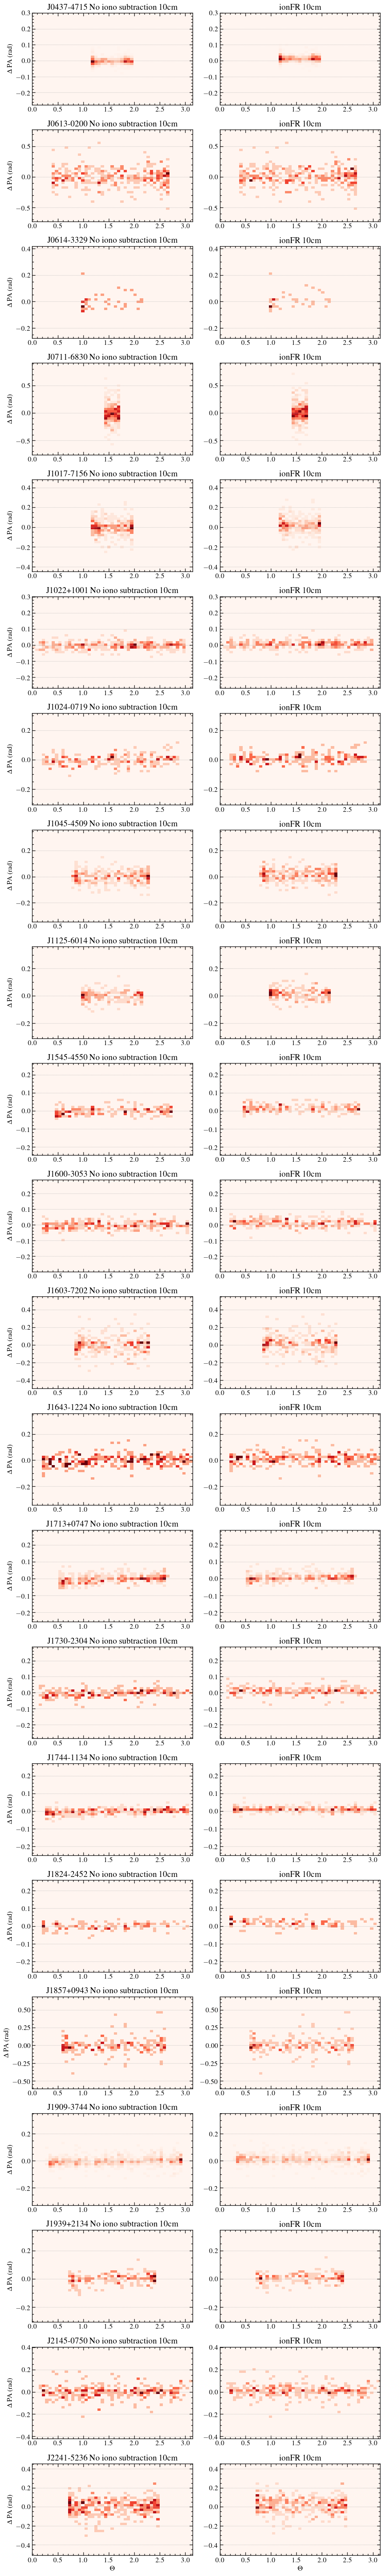

In [8]:
plt.subplots(figsize=(10,3*22),sharex=True,sharey=True)

k=0
for i,p in enumerate(PSR_NAME_LIST):
    try:
        
        toa_mjd = pulsars_noiono_10[i].TOAs[0]/sc.day + ppa.TREFd
        data_noiono = pulsars_noiono_10[i].DPA[0]
        data_ionfr = pulsars_ionfr_10[i].DPA[0]

        sun_pos = np.array( [ get_sun_loc( t ) for t in toa_mjd ] )
        psr_pos = pulsars_noiono_10[i].PSR_LOC
        sun_psr_angle = np.arccos( np.sum(np.array(sun_pos)*psr_pos[None,:],axis=1) )
        sort = np.argsort(sun_psr_angle)

        ymin = min(data_noiono[sort].min() , data_ionfr[sort].min() ) - 0.2
        ymax = max(data_noiono[sort].max() , data_ionfr[sort].max() ) + 0.2

        plt.subplot(22,2,2*k+1)
        plt.hist2d( sun_psr_angle[sort] , data_noiono[sort] ,bins=(np.linspace(0,np.pi,50),np.linspace(ymin,ymax,40)),cmap='Reds')
        plt.title(p+"      No iono subtraction 10cm")
        plt.ylabel(r"$\Delta$ PA (rad)")
        plt.grid(axis='y',linestyle=':')
        if k==21:
            plt.xlabel(r"$\Theta$")
            

        plt.subplot(22,2,2*k+2)
        plt.hist2d( sun_psr_angle[sort] , data_ionfr[sort] ,bins=(np.linspace(0,np.pi,50),np.linspace(ymin,ymax,40)),cmap='Reds')
        plt.title("ionFR 10cm")
        plt.grid(axis='y',linestyle=':')
        if k==21:
            plt.xlabel(r"$\Theta$")

        #plt.plot( sun_psr_angle[sort] , pulsars_ionfr_10[i].DPA[0][sort],'-',lw=0.5 ,label="ionosphere subtraction with ionFR, 10cm")
        

        k+=1

    except:
        pass
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
plt.savefig("psr_solar_angle_10_histogram.pdf")
#plt.close()

/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':
/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':
/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in arccos
  if __name__ == '__main__':
/opt/anaconda3/envs/ppa/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encounte

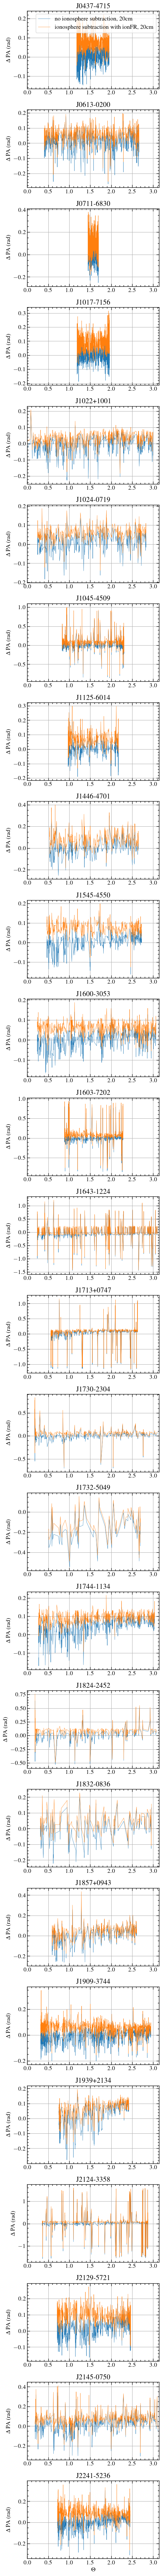

In [ ]:
# plt.figure(figsize=(5,3*26))
# k=0
# for i,p in enumerate(PSR_NAME_LIST):
#     try:
#         plt.subplot(26,1,k+1)
        
#         sun_pos = np.array( [ get_sun_loc( t ) for t in pulsars_noiono_20[i].TOAs[0]/sc.day + ppa.TREFd] )
#         psr_pos = pulsars_noiono_20[i].PSR_LOC
#         sun_psr_angle = np.arccos( np.sum(np.array(sun_pos)*psr_pos[None,:],axis=1) )
#         sort = np.argsort(sun_psr_angle)

#         plt.plot( sun_psr_angle[sort] , pulsars_noiono_20[i].DPA[0][sort],'-',lw=0.5 ,label="no ionosphere subtraction, 20cm")
#         plt.plot( sun_psr_angle[sort] , pulsars_ionfr_20[i].DPA[0][sort],'-',lw=0.5 ,label="ionosphere subtraction with ionFR, 20cm")
#         plt.title(p)
#         plt.xlim(0,np.pi)
#         if k==0:
#             plt.legend()
#         if k==25:
#             plt.xlabel(r"$\Theta$")
        
#         plt.ylabel(r"$\Delta$ PA (rad)")
#         plt.grid()
#         k+=1

#     except:
#         pass
# plt.subplots_adjust(hspace=0.3)
# plt.tight_layout()
# plt.savefig("psr_solar_angle_20.pdf")
# #plt.close()

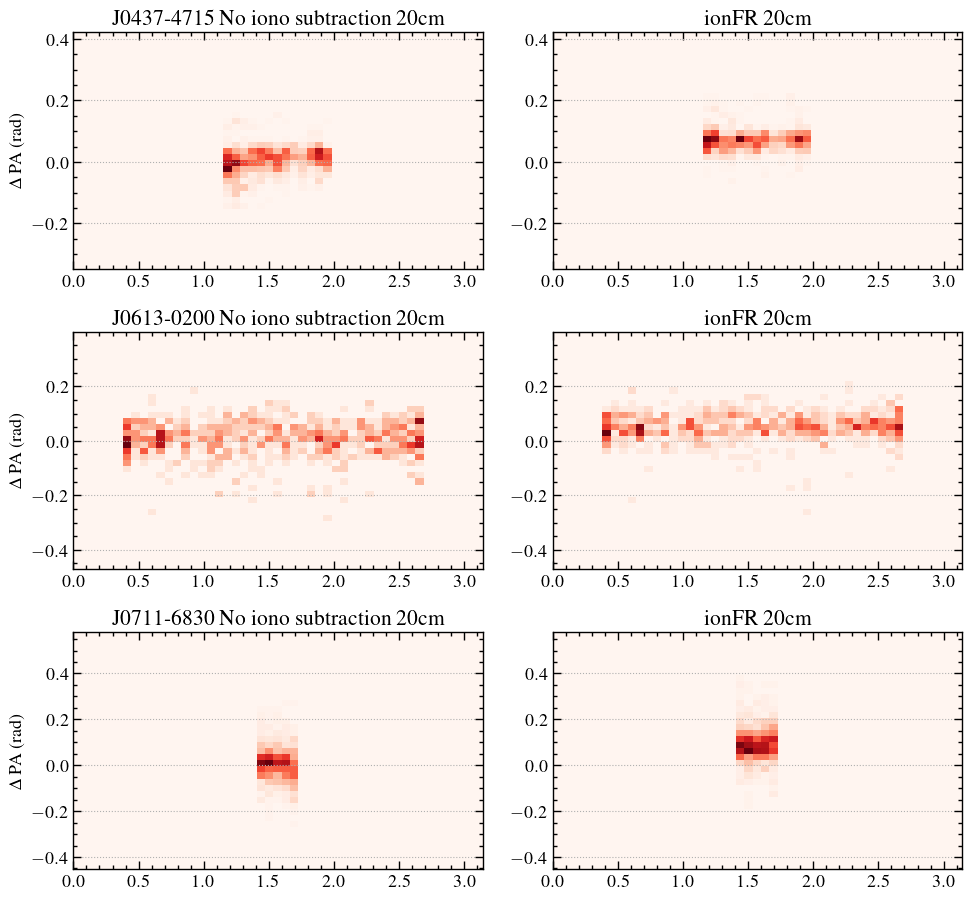

In [ ]:
plt.subplots(figsize=(10,3*26),sharex=True,sharey=True)

k=0
for i,p in enumerate(PSR_NAME_LIST[:4]):
    try:
        
        toa_mjd = pulsars_noiono_20[i].TOAs[0]/sc.day + ppa.TREFd
        data_noiono = pulsars_noiono_20[i].DPA[0]
        data_ionfr = pulsars_ionfr_20[i].DPA[0]

        sun_pos = np.array( [ get_sun_loc( t ) for t in toa_mjd ] )
        psr_pos = pulsars_noiono_20[i].PSR_LOC
        sun_psr_angle = np.arccos( np.sum(np.array(sun_pos)*psr_pos[None,:],axis=1) )
        sort = np.argsort(sun_psr_angle)

        ymin = min(data_noiono[sort].min() , data_ionfr[sort].min() ) - 0.2
        ymax = max(data_noiono[sort].max() , data_ionfr[sort].max() ) + 0.2

        plt.subplot(26,2,2*k+1)
        plt.hist2d( sun_psr_angle[sort] , data_noiono[sort] ,bins=(np.linspace(0,np.pi,50),np.linspace(ymin,ymax,40)),cmap='Reds')
        plt.title(p+"      No iono subtraction 20cm")
        plt.ylabel(r"$\Delta$ PA (rad)")
        plt.grid(axis='y',linestyle=':')
        if k==25:
            plt.xlabel(r"$\Theta$")


        plt.subplot(26,2,2*k+2)
        plt.hist2d( sun_psr_angle[sort] , data_ionfr[sort] ,bins=(np.linspace(0,np.pi,50),np.linspace(ymin,ymax,40)),cmap='Reds')
        plt.title("ionFR 20cm")
        plt.grid(axis='y',linestyle=':')
        if k==25:
            plt.xlabel(r"$\Theta$")
        
        k+=1

    except:
        pass
    
plt.subplots_adjust(hspace=0.3)
plt.tight_layout()
#plt.savefig("psr_solar_angle_20_histogram.pdf")
#plt.close()

# Mock Data test

Text(0.5, 1.0, 'axion signal (auto corr)')

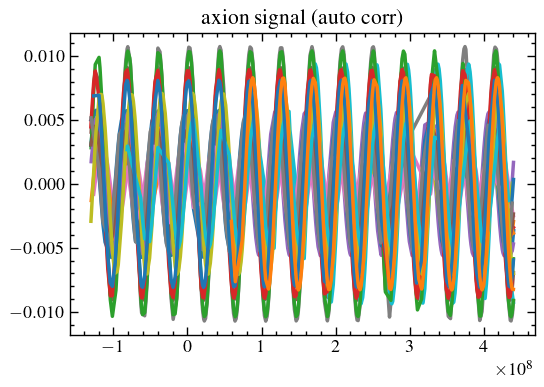

In [ ]:
# white background, full signal
DPA1 = array.Gen_Mock_Data(noise_type='white',adm_signal='full',mock_lma=-22.0 , mock_lSa=-2.5,seed=150)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-22.0 , mock_lSa=-2.5,seed=150)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )
plt.title("axion signal (auto corr)")

Text(0.5, 1.0, 'axion signal (full corr)')

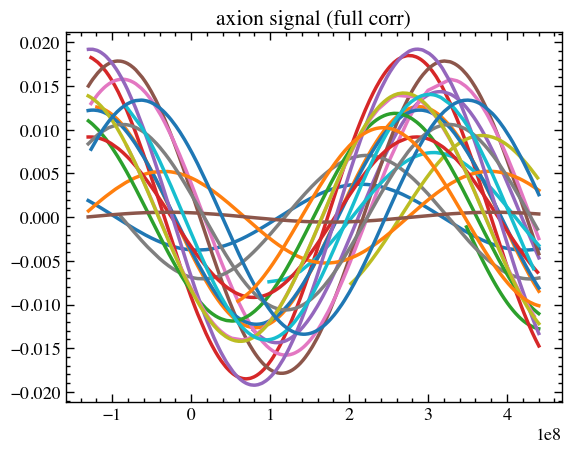

In [ ]:
# white background, full signal
DPA1 = array.Gen_Mock_Data(noise_type='white',adm_signal='full',mock_lma=-23.0 , mock_lSa=-2.5,seed=20)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-2.5,seed=20)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )
plt.title("axion signal (full corr)")

Text(0.5, 1.0, 'red noise ')

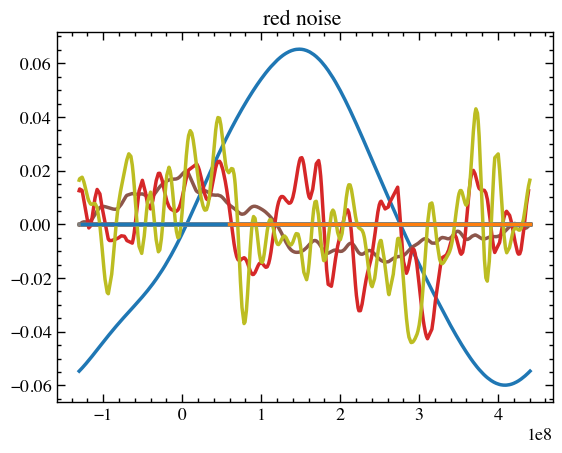

In [ ]:
# another comparison
DPA1 = array.Gen_Mock_Data(noise_type='red',adm_signal='full',mock_lma=-23.0 , mock_lSa=-8,seed=20)
DPA2 = array.Gen_Mock_Data(noise_type='white',adm_signal='none',mock_lma=-23.0 , mock_lSa=-8,seed=20)
for i in range(22):
    plt.plot(array.TOAs[i][0],DPA1[i][0] -DPA2[i][0] )
plt.title("red noise ")

# The script to collect the information from MCMC chains

In [ ]:
import glob
import numpy as np
def getbf(burn = 0 , printit=True , folder="./"):
   files = sorted(glob.glob(folder+'*/chain_1.txt'))[::-1] + sorted(glob.glob(folder+"*/chain_1.0.txt"))[::-1]\
      + sorted(glob.glob(folder+'*/*/chain_1.txt'))[::-1] + sorted(glob.glob(folder+"*/*/chain_1.0.txt"))[::-1]
   res = []
   ys = []
   #l10ma = []
   np.set_printoptions(precision=3)
   for file in files:
      try:
         chain = np.loadtxt(file,skiprows=burn)
         ul = np.percentile( chain[:,-5],[5,32,50,68,95] )
         
         chain0 = chain[chain[:,0]<0]
         chain1 = chain[chain[:,0]>=0]

         if len(chain1) ==0 :
            ul1 = np.repeat(np.nan,5)
         else:
            ul1 = np.percentile(chain1[:,-5],[5,32,50,68,95])

         if len(chain0) ==0 :
            ul0 = np.repeat(np.nan,5)
         else:
            ul0 = np.percentile(chain0[:,-5],[5,32,50,68,95])

         try:
            bestfit = chain[np.argmax(chain[:,-4]),[-7,-6,-5]]
         except:
            bestfit=""

         try:
            dlnpos = chain[:,-3].max()
         except:
            dlnpos = np.nan

         y = len(chain1)/len(chain)
         ys.append(y)
         res.append([ul0.tolist(),ul1.tolist(),ul.tolist()])
         if printit == True:
            print(file.split("/")[:-1],"|",np.histogram(chain[:,0],bins=[-1,0,1])[0],
            "|%.2f"%(ul0[-1]),"%.2f"%(ul1[-1]),"|%.4f"%(y/(1-y+1e-9)),"|%.2f"%dlnpos,"|","%.1f"%np.std(chain[:,-3]))
         #l10ma.append(float(file.split("/")[0].split("_")[-1]))

      except:
         if printit==True:
            print(file.split("/")[:-1],"|")
   ys = np.array(ys)
   lbf = np.log(ys/(1-ys));lbf
   return np.array(res),lbf


def bf_thermo(burn =0):
   folders = sorted(glob.glob("*/*"))[::-1]
   allZ = []
   for folder in folders:
      files = sorted(glob.glob(folder+"/chain*.txt"))
      beta = []
      lnlmean = []
      try:
         lnlikemax = []
         for f in files:
               temp = float( f.split("/")[-1].split("_")[-1][:-4] )
               beta.append(1/temp)
               chain = np.loadtxt(f,skiprows=burn)
               lnlikemax.append(chain[:,-3].max())
               lnlmean.append(np.mean(chain[:,-3]))
         beta = np.array(beta)
         sort = np.argsort(beta)
         beta = beta[sort]
         lnlmean = np.array(lnlmean)[sort]
         Z = np.sum((lnlmean[:-1] + lnlmean[1:])*np.diff(beta))/2
         allZ.append(Z)
         print(f.split("/")[:-1],"|",len(chain[:,0]),"|%.2f|"%Z,("["+"%.1f,"*len(lnlmean))%tuple(lnlmean)+"]","|%.2f"%(max(lnlikemax)) )
      except Exception as Ex:
         print(Ex)
         print(f.split("/")[:-1])
   return np.array(allZ)
